In [1]:
from packaging import version

import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats

from collections import defaultdict
import os

from tensorflow.python.summary.summary_iterator import summary_iterator
import tensorflow as tf
%matplotlib inline

2024-10-12 22:23:04.305640: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-12 22:23:04.305833: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-12 22:23:04.307548: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-12 22:23:04.329477: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-12 22:23:04.826727: W tensorflow/compiler/tf2tensorrt/utils/py_uti

In [2]:
log_dir = os.path.join(os.getcwd(), "../.runs/seq/cifar10")

In [3]:
experiments = os.listdir(log_dir)
experiments

['sgd_1_of_2',
 'mfvi_1_of_2',
 'mfvi_2_of_2',
 'sgd_2_of_2_from_split1_init',
 'sgd_2_of_2_stratified_from_split1_init',
 'sgd_2_of_2_stratified',
 'sgd_2_of_2',
 'mfvi_1_of_2_stratified',
 'mfvi_2_of_2_stratified',
 'sgd_1_of_2_stratified']

In [4]:
experiment = "sgd_1_of_2"

In [7]:
def parse_sgd_events(eventfile):
    value_by_tag = defaultdict(dict)
    for event in summary_iterator(eventfile):
        for value in event.summary.value:
            value_by_tag[value.tag][event.step] = tf.make_ndarray(value.tensor).squeeze()
    df = pd.DataFrame(value_by_tag).rename_axis("step")
    return df.drop(columns=['command']).astype(float)

In [35]:
def load_sgd_experiment_logs(experiment, experiment_instance=None, events_log=None):
    if experiment_instance is None:
        instances = os.listdir(os.path.join(log_dir, experiment))
        assert len(instances) == 1, f"Manually need to provice experiment instance: {instances}"
        experiment_instance = instances[0]
    if events_log is None:
        events_log = max((os.path.getmtime(os.path.join(log_dir, experiment, experiment_instance, filename)), filename)
                                for filename in filter(
                                    lambda filename: filename.startswith("event"),
                                    os.listdir(os.path.join(log_dir, experiment, experiment_instance))
                                ))[1]
    eventfile = os.path.join(log_dir, experiment, experiment_instance, events_log)
    df = parse_sgd_events(eventfile)
    return df.iloc[list(range(10, len(df), 10)) + [-1]]

In [80]:
df_sgd_split1 = load_sgd_experiment_logs("sgd_1_of_2")
# df_sgd_split2 = load_sgd_experiment_logs("sgd_2_of_2")
df_sgd_split2_from_split1_init = load_sgd_experiment_logs(
    "sgd_2_of_2_from_split1_init",
    experiment_instance="sgd_mom_0.9__lr_sch_i_3e-07___epochs_500_wd_10.0_batchsize_80_temp_1.0__seed_1",
    events_log="events.out.tfevents.1727565335.garchie.32121.0.v2"
)

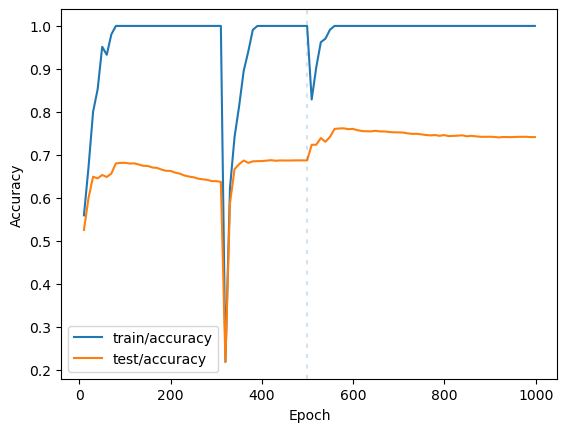

In [58]:
pd.concat([
    df_sgd_split1,#.rolling(20, min_periods=1).mean(),
    df_sgd_split2_from_split1_init.reset_index().assign(step=lambda df: df.step+df_sgd_split1.index.max()).set_index("step"),#.rolling(20, min_periods=1).mean()
])[['train/accuracy', 'test/accuracy']].plot()
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.axvline(x=df_sgd_split1.index.max(), ymin=0, ymax=1, alpha=0.2, dashes=(2,3))

In [81]:
df_sgd_split1_stratified = load_sgd_experiment_logs("sgd_1_of_2_stratified")
df_sgd_split2_stratified_from_split1_init = load_sgd_experiment_logs("sgd_2_of_2_stratified_from_split1_init")

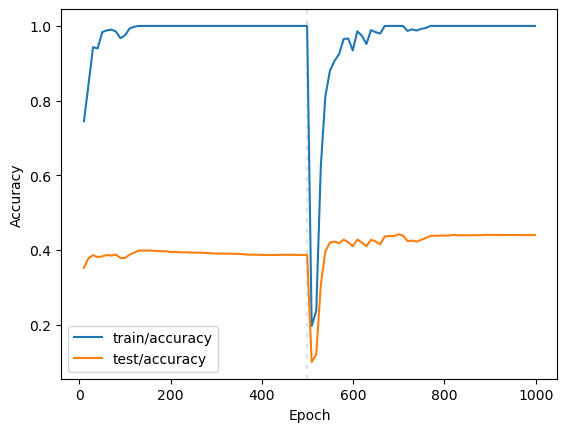

In [82]:
pd.concat([
    df_sgd_split1_stratified,
    df_sgd_split2_stratified_from_split1_init.reset_index().assign(step=lambda df: df.step+df_sgd_split1_stratified.index.max()).set_index("step"),
])[['train/accuracy', 'test/accuracy']].plot()
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.axvline(x=df_sgd_split1_stratified.index.max(), ymin=0, ymax=1, alpha=0.2, dashes=(2,3))

In [71]:
def parse_mfvi_events(eventfile):
    value_by_tag = defaultdict(dict)
    for event in summary_iterator(eventfile):
        for value in event.summary.value:
            value_by_tag[value.tag][event.step] = tf.make_ndarray(value.tensor).squeeze()
    df = pd.DataFrame(value_by_tag).rename_axis("step")
    # TODO generate insights from sigma histograms
    return df.drop(columns=['command', 'MFVI/param_stds']).astype(float)
def load_mfvi_experiment_logs(experiment, experiment_instance=None, events_log=None):
    if experiment_instance is None:
        instances = os.listdir(os.path.join(log_dir, experiment))
        assert len(instances) == 1, f"Manually need to provice experiment instance: {instances}"
        experiment_instance = instances[0]
    if events_log is None:
        events_log = max((os.path.getmtime(os.path.join(log_dir, experiment, experiment_instance, filename)), filename)
                                for filename in filter(
                                    lambda filename: filename.startswith("event"),
                                    os.listdir(os.path.join(log_dir, experiment, experiment_instance))
                                ))[1]
    eventfile = os.path.join(log_dir, experiment, experiment_instance, events_log)
    df = parse_mfvi_events(eventfile)
    return df.iloc[list(range(10, len(df), 10)) + [-1]]

In [112]:
df_mfvi_split1 = load_mfvi_experiment_logs("mfvi_1_of_2")
df_mfvi_split2 = load_mfvi_experiment_logs(
    "mfvi_2_of_2",
    experiment_instance="mfvi_initsigma_0.01_meaninit__opt_adam__lr_sch_i_0.0001___epochs_300_pretr_2913792_batchsize_80_temp_1.0__seed_0",
)
df_mfvi = load_mfvi_experiment_logs(
    "../../vi/cifar10/test",
    experiment_instance="mfvi_initsigma_0.01__opt_adam__lr_sch_i_0.0001___epochs_300_wd_5.0_batchsize_80_temp_1.0__seed_11",
    events_log="events.out.tfevents.1726942795.garchie.30517.0.v2"
)

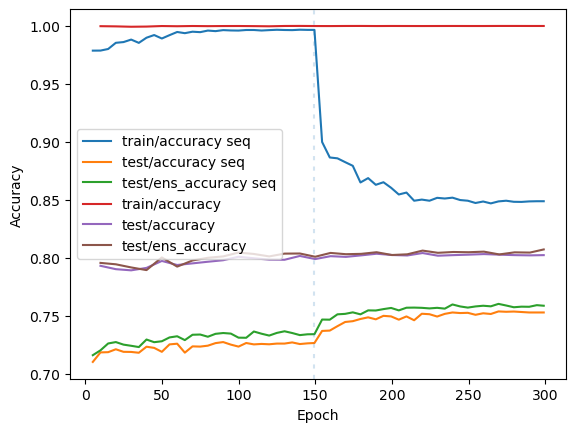

In [113]:
fig, ax = plt.subplots()
seq_plot_df = pd.concat([
    df_mfvi_split1,
    df_mfvi_split2.reset_index().assign(step=lambda df: df.step+df_mfvi_split1.index.max()).set_index("step"),
])[['train/accuracy', 'test/accuracy', 'test/ens_accuracy']].add_suffix(" seq")
# Halve the epochs as each epoch is only using half the dataset
seq_plot_df.index /= 2.0
seq_plot_df.plot(ax=ax)
ax.axvline(x=seq_plot_df.index.max()/2.0, ymin=0, ymax=1, alpha=0.2, dashes=(2,3))
df_mfvi[['train/accuracy', 'test/accuracy', 'test/ens_accuracy']].plot(ax=ax)
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epoch")
plt.show()

In [114]:
df_mfvi_split1_stratified = load_mfvi_experiment_logs("mfvi_1_of_2_stratified")
df_mfvi_split2_stratified = load_mfvi_experiment_logs(
    "mfvi_2_of_2_stratified",
    experiment_instance="mfvi_initsigma_0.01_meaninit__opt_adam__lr_sch_i_0.0001___epochs_300_pretr_7794560_batchsize_80_temp_1.0__seed_0",
)

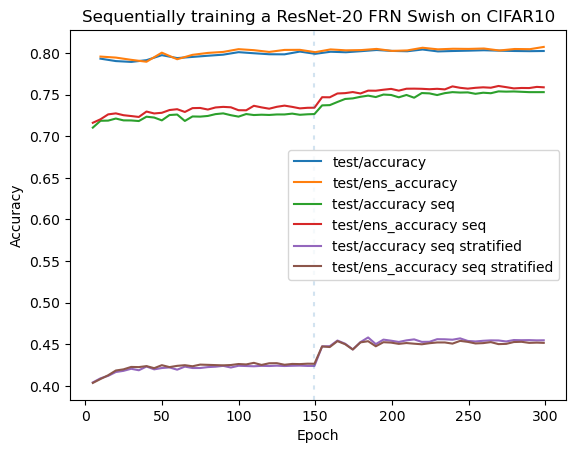

In [134]:
fig, ax = plt.subplots()
FIELDS_TO_PLOT = [
    "test/accuracy",
    "test/ens_accuracy"
]
SGD_FIELDS_TO_PLOT = [
    "test/accuracy"
]
ADD_SGD_BASELINE = False
# Plot all-in-one-go training
df_mfvi[FIELDS_TO_PLOT].plot(ax=ax)
# Plot randomized sequential training
seq_plot_df = pd.concat([
    df_mfvi_split1,
    df_mfvi_split2.reset_index().assign(step=lambda df: df.step+df_mfvi_split1.index.max()).set_index("step"),
])[FIELDS_TO_PLOT].add_suffix(" seq")
# Halve the epochs as each epoch is only using half the dataset
seq_plot_df.index /= 2.0
seq_plot_df.plot(ax=ax)
# Plot stratified sequential training
seq_plot_df = pd.concat([
    df_mfvi_split1_stratified,
    df_mfvi_split2_stratified.reset_index().assign(step=lambda df: df.step+df_mfvi_split1_stratified.index.max()).set_index("step"),
])[FIELDS_TO_PLOT].add_suffix(" seq stratified")
# Halve the epochs as each epoch is only using half the dataset
seq_plot_df.index /= 2.0
seq_plot_df.plot(ax=ax)
if ADD_SGD_BASELINE:
    # Add SGD baseline
    seq_plot_df = pd.concat([
        df_sgd_split1,
        df_sgd_split2_from_split1_init.reset_index().assign(step=lambda df: df.step+df_sgd_split1.index.max()).set_index("step"),
    ])[SGD_FIELDS_TO_PLOT].add_suffix(" sgd baseline")
    seq_plot_df.index /= 2.0
    seq_plot_df.plot(ax=ax)
    # Add SGD stratified baseline
    seq_plot_df = pd.concat([
        df_sgd_split1_stratified,
        df_sgd_split2_stratified_from_split1_init.reset_index().assign(step=lambda df: df.step+df_sgd_split1_stratified.index.max()).set_index("step"),
    ])[SGD_FIELDS_TO_PLOT].add_suffix(" sgd stratified baseline")
    seq_plot_df.index /= 2.0
    seq_plot_df.plot(ax=ax)
# Format figure
ax.axvline(x=seq_plot_df.index.max()/2.0, ymin=0, ymax=1, alpha=0.2, dashes=(2,3))
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epoch")
ax.set_title("Sequentially training a ResNet-20 FRN Swish on CIFAR10")
plt.show()

In [173]:
def winsorize(xs: pd.Series, q_low=0., q_high=1.):
    return xs.clip(*xs.quantile([q_low, q_high]))